In [1]:
import pandas as pd
import graphlab as gl
import numpy as np
from IPython.core.display import display
from scipy.spatial.distance import cosine,euclidean,pdist,squareform,sqeuclidean
from sklearn.metrics.pairwise import pairwise_distances
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import entropy
from numpy.linalg import norm
from jenks import jenks
from itertools import chain,tee, izip
from urllib import unquote_plus
from titlecase import titlecase
from itertools import combinations
import itertools
import seaborn

This non-commercial license of GraphLab Create is assigned to jlorince@indiana.edu and will expire on May 03, 2017. For commercial licensing options, visit https://dato.com/buy/.


2016-06-02 13:52:54,519 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.9 started. Logging: /tmp/graphlab_server_1464889973.log


In [2]:
# GLOBAL PARAMS
SESSION_THRESHOLD = 1800 # 30 minutes
MIN_LENGTH = 5 # Minimum number of scrobbles in a patch

In [5]:
### Load some example data
fi = "../testData/mylistening.txt"
#fi = "../testData/test_listening_data.tsv"
me = pd.read_table(fi,header=None,
            names=['user_id','item_id','artist_id','ts'],parse_dates=['ts']).sort_values(by='ts')
### Build artist_name:artist_idx dict from 
artist_idx = {}
for line in open('../GenreModeling/data/vocab_idx'):
    line = line.strip().split('\t')
    artist_idx[line[0]] = int(line[1])
### Load artist feature matrix
features = np.load('../GenreModeling/data/features/lda_artists/features_190.npy')

In [6]:
### Build artist_id:artist_name and artist_name:artist_idx dicts from database data
artist_ids = {}
artist_names = {}
for line in open('../GenreModeling/data/artist_ids'):
    line = line.strip().split('\t')
    artist_ids[int(line[0])] = line[1]
    artist_names[line[1]] = int(line[0])
    
# Lookup function to get features for a given artist ID or artist name
def get_features(aid=None,artist_name=None):
    if artist_name is None:
        artist_name = artist_ids.get(aid)
        if not artist_name: 
            return np.repeat(np.nan,features.shape[1])
    return features[artist_idx[artist_name]]

# Function for Jensen Shannon Distance (Sqrt of Jensen Shannon Divergence)
def JSD(P, Q):
    if np.all(np.isnan(P)) or np.all(np.isnan(Q)):
        return np.nan
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return np.sqrt(np.clip(0.5 * (entropy(_P, _M) + entropy(_Q, _M)),0,1))

# Function to calculate distance between any two artists 
def calc_sim(artist1,artist2,metric='cosine'):
    if np.isnan(artist1) or np.isnan(artist2):
        return np.nan
    if artist1==artist2:
        return 0.0
    features1 = get_features(artist1)
    if np.all(np.isnan(features1)): return np.nan
    features2 = get_features(artist2)
    if np.all(np.isnan(features2)): return np.nan
    if metric == 'JSD':
        return JSD(features1,features2)
    elif metric == 'cosine':
        return cosine(features1,features2)
    elif metric == 'euclidean':
        return sqeuclidean(features1,features2)

# for proper formatting of artist names
def formatter(s):
    if s:
        try: return titlecase(unquote_plus(s))
        except: return s
    return 'UNKNOWN'

# Just a clean format for presenting example dataframes 
def pres_format(input_df):
    df = input_df.copy()
    df = df[['ts','artist_name','dist']].reset_index(drop=True)
    df.columns = ['timestamp','artist','distance']
    df['artist'] = df['artist'].apply(formatter)
#    df['previous artist'] = df['previous artist'].apply(formatter)
    return df

In [7]:
# All pre-formatting of data
new = me.copy()
new['before'] = new.shift(1)['artist_id']
new['td'] = new['ts']-new.shift(1)['ts']
new['td'] = new['td'].astype(int) / 10**9
new['artist_name'] = new.apply(lambda row: artist_ids.get(row['artist_id']),axis=1)
new['before_name'] = new.shift(1)['artist_name']
new = new[['ts','artist_id','before','td','artist_name','before_name']]
new['dist'] = new.apply(lambda row: calc_sim(row['artist_id'],row['before']),axis=1)
new['features'] = new['artist_name'].apply(lambda a: get_features(artist_name=a))
new = new.reset_index(drop=True)

In [8]:
### Add session index information
session_idx = 0
session_indices = []
for val in new['td']>=SESSION_THRESHOLD:
    if val:
        session_idx +=1
    session_indices.append(session_idx)
new['session'] = session_indices

### deletes session shorter than MIN_LENGTH
#session_counts = new['session'].value_counts()
#new = new[new['session'].isin(session_counts[session_counts>=MIN_LENGTH].index)]

In [9]:
### Get top artist info

top_artists = new['artist_id'].value_counts().reset_index()
top_artists.columns = ['artist_id','scrobbles']
top_artists['artist_name'] = top_artists['artist_id'].apply(lambda x: artist_ids.get(x))


In [10]:
### If we want to remove sessions with unknown artists (but let's not for now)
def remove_sessions_with_unknowns(df):
    if df['artist_name'].hasnans:
        return None
    else:
        return df
#new = new.groupby('session').apply(remove_sessions_with_unknowns).reset_index(drop=True)


In [12]:
### Add patch index information
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return izip(a, b)

s=20
dist_thresh = 0.2

def patch_segmenter(df,shuffle=True):
    l = df['artist_id']
    indices = list(np.array([len(list(v)) for g,v in itertools.groupby(l)][:-1]).cumsum())
    new_indices = []

    for b in indices:
        try:
            dist = cosine(df.iloc[b]['features'],df.iloc[b-1]['features'])
        except ValueError:
            dist = 1.
        #print b,test.iloc[b-1]['artist_name'],test.iloc[b]['artist_name'],dist
        if dist >= dist_thresh:
            new_indices.append(b)
    
    
    if new_indices:

        last_patch = False
        final_indices = []
        for i,(a,b) in enumerate(pairwise([0]+new_indices+[len(df)])):
            if b-a>=MIN_LENGTH:
                final_indices.append(a)
                last_patch = True
            else:
                if last_patch:
                    final_indices.append(a)
                last_patch = False
        
        return final_indices,new_indices
    return new_indices,new_indices
        
test = new.copy()
indices_shuffle = np.zeros(len(test),dtype=int)
indices_simple = np.zeros(len(test),dtype=int)
offset_shuffle = 0
idx_shuffle=0
offset_simple = 0
idx_simple=0

for session in test.groupby('session'):
    result_shuffle,result_simple = patch_segmenter(session[1])
    n=len(session[1])
    
    if len(result_shuffle)==0:
        indices_shuffle[offset_shuffle:offset_shuffle+n] = idx_shuffle
        idx_shuffle+=1
    else:
        indices_shuffle[offset_shuffle:offset_shuffle+result_shuffle[0]] = idx_shuffle
        idx_shuffle+=1
        for v, w in pairwise(result_shuffle):
            indices_shuffle[offset_shuffle+v:offset_shuffle+w] = idx_shuffle
            idx_shuffle+=1
        indices_shuffle[offset_shuffle+result_shuffle[-1]:offset_shuffle+result_shuffle[-1]+n] = idx_shuffle
        idx_shuffle+=1
    offset_shuffle += n

    if len(result_simple)==0:
        indices_simple[offset_simple:offset_simple+n] = idx_simple
        idx_simple+=1
    else:
        indices_simple[offset_simple:offset_simple+result_simple[0]] = idx_simple
        idx_simple+=1
        for v, w in pairwise(result_simple):
            indices_simple[offset_simple+v:offset_simple+w] = idx_simple
            idx_simple+=1
        indices_simple[offset_simple+result_simple[-1]:offset_simple+result_simple[-1]+n] = idx_simple
        idx_simple+=1
    offset_simple += n


    
if result_shuffle:
    indices_shuffle[offset_shuffle+result_shuffle[-1]:] = idx_shuffle
else:
    indices_shuffle[offset_shuffle:] = idx_shuffle
    
if result_simple:
    indices_simple[offset_simple+result_simple[-1]:] = idx_simple
else:
    indices_simple[offset_simple:] = idx_simple

test['patch_idx_shuffle'] = indices_shuffle
test['patch_idx_simple'] = indices_simple

In [13]:
# add artist block info
### https://stackoverflow.com/questions/14358567/finding-consecutive-segments-in-a-pandas-data-frame

test['block'] = (test['artist_id'].shift(1) != test['artist_id']).astype(int).cumsum()


In [14]:
test[test['session']==20]

,ts,artist_id,before,td,artist_name,before_name,dist,features,session,patch_idx_shuffle,patch_idx_simple,block
208,2007-03-02 03:25:22,12874,1727.0,68421.0,squarepusher,radiohead,0.898677,"[2.9450533735e-07, 1.41362561928e-06, 2.945053...",20,24,134,137
209,2007-03-02 03:25:53,2189,12874.0,31.0,the+who,squarepusher,0.989141,"[0.000794901067119, 0.000383332465272, 0.00046...",20,24,135,138
210,2007-03-02 03:29:15,1727,2189.0,202.0,radiohead,the+who,0.486272,"[0.000428501969522, 3.62170571871e-05, 6.74461...",20,24,136,139
211,2007-03-02 03:33:41,424,1727.0,266.0,red+hot+chili+peppers,radiohead,0.261287,"[0.00113307625286, 0.00401911781066, 2.2995622...",20,24,137,140
212,2007-03-02 03:37:19,659,424.0,218.0,%22weird+al%22+yankovic,red+hot+chili+peppers,0.776628,"[4.9416179718e-06, 0.00895484939303, 0.0163873...",20,24,138,141
213,2007-03-02 03:39:38,3593,659.0,139.0,gorillaz,%22weird+al%22+yankovic,0.610327,"[0.000335318195727, 0.000342407510021, 0.00180...",20,24,139,142
214,2007-03-02 03:47:50,7432,3593.0,492.0,fatboy+slim,gorillaz,0.398149,"[0.000598386557643, 0.000367025536486, 0.00312...",20,24,140,143
215,2007-03-02 03:53:06,166,7432.0,316.0,sufjan+stevens,fatboy+slim,0.903825,"[0.00163614277975, 0.00120421755383, 2.6849889...",20,24,141,144
216,2007-03-02 03:56:30,7175,166.0,204.0,the+offspring,sufjan+stevens,0.974887,"[1.50881791794e-05, 0.00808933853112, 6.961307...",20,24,142,145
217,2007-03-02 03:59:23,507,7175.0,173.0,beck,the+offspring,0.764417,"[0.000500772801594, 0.000969879562416, 7.31757...",20,24,143,146


In [61]:
# patch summary data methods

def patch_stats(df,agg_stats=True):
    first = df.iloc[0]
    n = len(df)
    start = first['ts']
    if agg_stats:
        artists = df['artist_id'].values
        if (n==1) or (len(df['artist_id'].unique())==1):
            diversity = 0.
            centroid = first['features']
        else:
            #diversity = (len(df['artist_id'].unique())/float(len(df))) * df['dist'][1:].mean()
            features = np.array([get_features(i) for i in df['artist_id']])
            centroid = np.nanmean(features,axis=0)
            diversity = np.nanmean(pdist(features,metric='cosine'))
            #diversity = (((len(df['artist_id'].unique())-1)/float(len(df)-1)) + df['dist'][1:].mean())/2.
            #centroid = np.nanmean([get_features(i) for i in df['artist_id']],axis=0)
        
        return pd.Series({'diversity':diversity,'centroid':centroid,'start_ts':start,'n':n,'artists':artists})
    else:
        artist = first['artist_id']
        return pd.Series({'start_ts':start,'n':n,'artist_idx':artist})
    

basis = 'patch_idx_shuffle'
#basis = 'block'
if basis=='block': agg_stats=False
else: agg_stats = True
result = test.groupby(basis).apply(patch_stats,agg_stats)#.reset_index(level=1,drop=True)
result['start_idx'] = result['n'].cumsum().shift(1).fillna(0).astype(int)
    



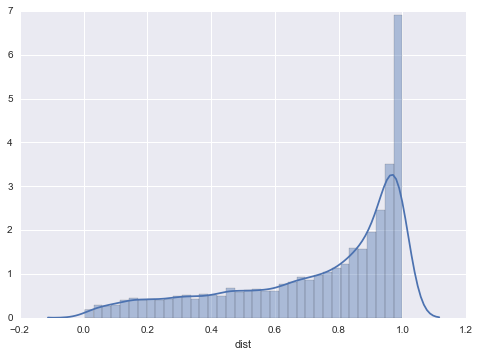

In [53]:
result['before'] = result['artist_idx'].shift(1)
result['dist'] = result.apply(lambda row: calc_sim(row['artist_idx'],row['before']),axis=1)
seaborn.distplot(result['dist'].dropna())

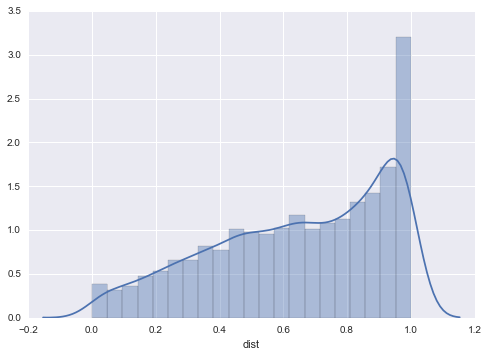

In [69]:
### Session clustering
result['prev_centroid'] = result['centroid'].shift(1)
def centroid_dist(row):
    if np.any(np.isnan(row['centroid'])) or np.any(np.isnan(row['prev_centroid'])):
        return np.nan
    else:
        return cosine(row['centroid'],row['prev_centroid'])
result['dist'] = result.apply(centroid_dist,axis=1)
result.head()
#seaborn.distplot(result['dist'][result['dist']>0])
filtered = result[result.apply(lambda row: ~np.all(row['centroid']==row['prev_centroid']),axis=1)]
seaborn.distplot(filtered['dist'].dropna())
#result[result['dist']<0.3]

In [ ]:
brks2 = jenks(result[result['n']>=5]['diversity'].dropna(),2)
brks3 = jenks(result[result['n']>=5]['diversity'].dropna(),3)
print brks2,brks3
#ax = seaborn.distplot(result[result['n']>=5]['diversity'].dropna(),norm_hist=False,bins=25)
ax = seaborn.distplot(result[(result['n']>=5)&(result['diversity']>0)]['diversity'].dropna(),bins=25)
# ax.axvline(brks2[1],c='k',ls='--')
# ax.axvline(brks3[1],c='r',ls='--')
# ax.axvline(brks3[2],c='r',ls='--')
#ax.axvline(brks[2],c='k',ls='--')
#ax.set_yscale('log')
ax.set_xlim(0,1);


In [ ]:
from scipy.spatial.distance import sqeuclidean
new['dist_euc'] = new.apply(lambda row: calc_sim(row['artist_id'],row['before'],metric='euclidean'),axis=1)


In [ ]:
new['dist_euc'].describe()

In [ ]:
#seaborn.jointplot(x='dist',y='dist_euc',data=new,kind='kde')
from scipy.stats import pearsonr,spearmanr
print pearsonr(new['dist'].dropna(),new['dist_euc'].dropna())
print spearmanr(new['dist'].dropna(),new['dist_euc'].dropna())


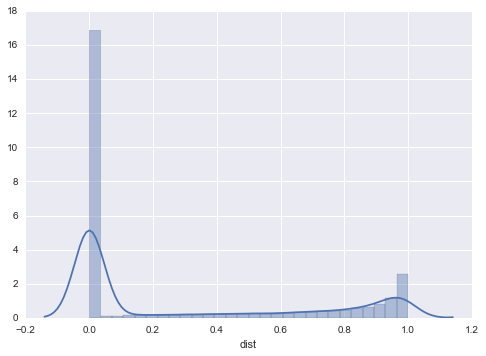

In [154]:
#seaborn.distplot(new['dist'][new['dist']>0],norm_hist=False)
seaborn.distplot(new['dist'].dropna())

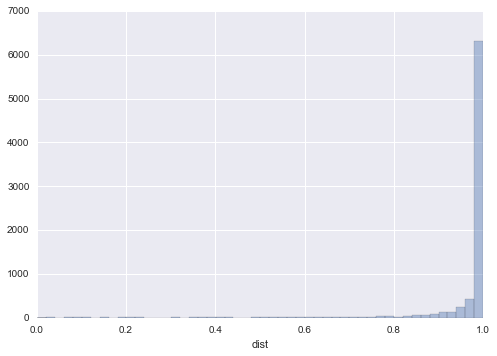

In [116]:
randhop = pd.DataFrame({'a':np.random.randint(0,112312,100000)})
randhop['prev'] = randhop['a'].shift(1)
randhop['dist'] = randhop.apply(lambda row: calc_sim(row['a'],row['prev']),axis=1)
seaborn.distplot(randhop['dist'].dropna(),kde=False,norm_hist=False)

In [151]:
#seaborn.distplot(randhop['dist'].dropna(),kde=False,norm_hist=False)
bins = np.arange(0,1.01,0.05)
vals = np.histogram(new['dist'][new['dist']>0],bins=bins)[0]
vals = vals/float(vals.sum())
vals2 = np.histogram(randhop['dist'].dropna(),bins=bins)[0]
vals2/float(vals2.sum());

In [163]:
#plt.plot(bins[:-1],vals/vals2)
n_bins=1000.
bin_width = 1/n_bins
np.arange(0,1+bin_width,1/n_bins)

array([ 0.   ,  0.001,  0.002, ...,  0.998,  0.999,  1.   ])

/Users/jaredlorince/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  if __name__ == '__main__':


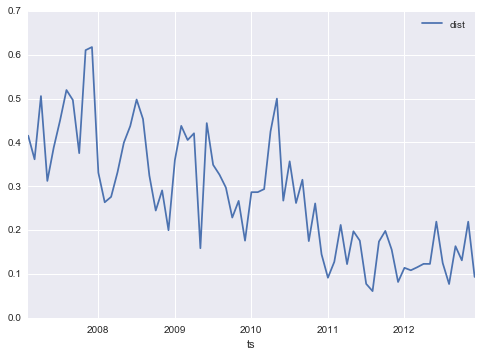

In [114]:
new[['ts','dist']].set_index('ts').resample('M',how='mean').plot()